<a href="https://colab.research.google.com/github/MenDeLeeVe/Cars/blob/main/Sound_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import IPython
from IPython.display import Audio
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split, ConcatDataset
from torch.distributions.normal import Normal
import torchvision.utils as vutils
import torch.nn.functional as F
import torch.nn.utils as nn_utils
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
import librosa
import librosa.display
import soundfile as sf
!git clone https://github.com/MenDeLeeVe/Cars.git
!pip install torch-audiomentations
from torch_audiomentations import Compose, AddColoredNoise, Gain, PolarityInversion, Shift, PitchShift
!git clone https://github.com/zoders/emg_gestures_dataset.git
!git clone https://github.com/MenDeLeeVe/Models.git

fatal: destination path 'Cars' already exists and is not an empty directory.
fatal: destination path 'emg_gestures_dataset' already exists and is not an empty directory.
fatal: destination path 'Models' already exists and is not an empty directory.


In [ ]:
data_dir = './Cars'
data_labels = os.listdir(data_dir)
data = []
labels = []
sr = 8000

label_to_idx = {'.git': 2, 'acceleration': 0, 'breaking': 1}

for label in data_labels:
  if label[0]=='.':
    continue
  file_names = os.listdir(os.path.join(data_dir,label))
  for fname in file_names:
      signal, samplerate = librosa.load(os.path.join(data_dir,label,fname), sr=sr, mono=True)
      signal = signal - np.mean(signal)
      data.append(signal)
      labels.append(label_to_idx[label])

min_len = min(signal.shape[0] for signal in data)
#print(min_len)

idx = 0
for idx, signal in enumerate(data):
  data[idx] = signal[:min_len]

data = np.array(data)
#display(IPython.display.Audio(data[0], rate = sr))
#print(data.shape,labels)

<ipython-input-103-557044d86951>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, samplerate = librosa.load(os.path.join(data_dir,label,fname), sr=sr, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
# Загрузка данных
def get_dataset(dataset_path):
    data = []
    labels = []
    muap_paths = []

    # Получаем список папок, игнорируя скрытые файлы
    folders = ['0','1']

    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)

        # Получаем список файлов в папке, игнорируя скрытые файлы
        muap_files = [f for f in os.listdir(folder_path)
                     if not f.startswith('.') and os.path.isfile(os.path.join(folder_path, f))]

        for muap_file in muap_files:
            path = os.path.join(folder_path, muap_file)
            muap_paths.append(path)

    random.seed(42)
    random.shuffle(muap_paths)

    for muap_path in muap_paths:
        try:
            muap = np.loadtxt(muap_path)
            data.append(muap)
            label = os.path.basename(os.path.dirname(muap_path))
            labels.append(label)
        except Exception as e:
            print(f"Ошибка при загрузке файла {muap_path}: {str(e)}")
            continue
    print
    return np.asarray(data, dtype=np.float32), np.asarray(labels, dtype=np.long)

In [ ]:
# Предобработка данных
signals, actions = get_dataset("/content/emg_gestures_dataset/gestures")
signals = signals[:,:]  # Берем все данные
actions = actions[:]

# Удаляем выбросы (где сумма абсолютных значений > 50)
tmp = np.sum(np.abs(signals), axis=1)
signals = np.delete(signals, tmp > 50, axis=0)
actions = np.delete(actions, tmp > 50, axis=0)

In [ ]:
print(actions.shape)

(2363,)


In [ ]:
AUGMENTATIONS = [
    #AddColoredNoise(min_snr_in_db=0.1, max_snr_in_db=1.0, p=1.0),
    Gain(min_gain_in_db=-1.0, max_gain_in_db=1.0, p=1.0),
    PolarityInversion(p=1.0),
    Shift(min_shift=-0.2, max_shift=0.2, p=1.0),
    PitchShift(min_transpose_semitones=-5, max_transpose_semitones=5, p=1.0, sample_rate=sr),
]

def random_augment_one(audio_tensor, sample_rate):
    num_augs = random.randint(0, 3)
    chosen_augs = random.sample(AUGMENTATIONS, num_augs)
    random.shuffle(chosen_augs)
    apply_augmentation = Compose(transforms=chosen_augs)
    augmented = apply_augmentation(audio_tensor, sample_rate=sr)
    return augmented

augmented_data = []
augmented_labels = []

for id in range(len(data)):
  x = torch.tensor(data[id], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
  for j in range(10):
    augmented = random_augment_one(x, sr)
    augmented_data.append(augmented.cpu().numpy())
    augmented_labels.append(labels[id])

augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

/usr/local/lib/python3.11/dist-packages/torch_audiomentations/core/transforms_interface.py:76: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = Gain(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch_audiomentations/core/transforms_interface.py:76: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = PolarityInversion(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch_audiomentations/core/transforms_interface.py:76: FutureWarning: Transforms now expect an `output_ty

In [ ]:
j = 0
sorted_signals = []
sorted_actions = []
for i, label in enumerate(augmented_labels):
    while label != actions[j]:
        j += 1
    sorted_signals.append(signals[j])
    sorted_actions.append(int(actions[j]))
    j += 1

sorted_signals = np.array(sorted_signals)

In [ ]:
tensor_data = torch.tensor(augmented_data, dtype=torch.float32).squeeze(1)
tensor_labels = torch.tensor(augmented_labels, dtype=torch.long)
tensor_signals = torch.tensor(sorted_signals, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(tensor_data, tensor_labels, tensor_signals)
val_percent = 0.1
n_total = len(dataset)
n_val = int(n_total * val_percent)
n_train = n_total - n_val
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
loader = DataLoader(train_dataset, batch_size=49, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=13, shuffle=True)


In [ ]:
print(dataset.tensors[2].shape)

torch.Size([980, 1, 2000])


In [ ]:
def set_seed(seed_value=42):
    # Python's built-in random module
    random.seed(seed_value)
    # NumPy
    np.random.seed(seed_value)
    # PyTorch
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
set_seed(42)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
sounds, labels, signals = next(iter(loader))
print(sounds.shape, labels.shape, signals.shape)

torch.Size([49, 1, 6067]) torch.Size([49]) torch.Size([49, 1, 2000])


[0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 1 1 1 0 1 1 0 0 1 0 1 0]


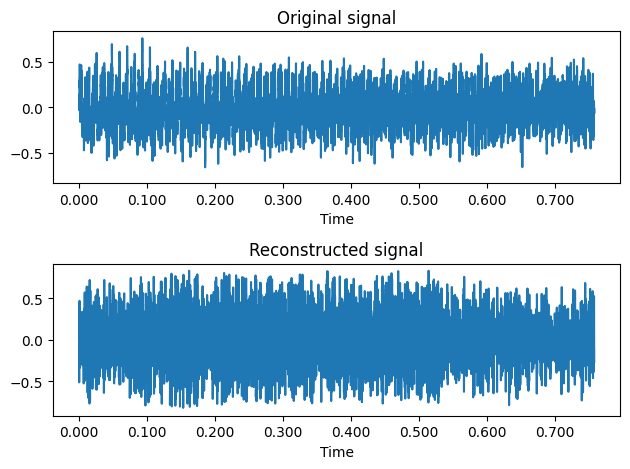

In [ ]:
print(np.array(labels))
signal_and_augmented_signal(sounds[0].squeeze().numpy(),sounds[2].squeeze().numpy(),sr)
display(IPython.display.Audio(sounds[17].cpu().squeeze() , rate = sr))
display(IPython.display.Audio(sounds[4].cpu().squeeze() , rate = sr))

In [ ]:
def signal_and_augmented_signal(signal, reconstructed_signal, sr):
    fig, ax = plt.subplots(nrows=2,)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title="Original signal")
    librosa.display.waveshow(reconstructed_signal, sr=sr, ax=ax[1])
    ax[1].set(title="Reconstructed signal")
    plt.tight_layout()
    plt.show()

# EMG

In [ ]:
class EMGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EMGModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 40, kernel_size=200, stride=1, padding='same')
        self.conv2 = nn.Conv1d(40, 25, kernel_size=10, stride=1, padding='same')
        self.pool1 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(25, 100, kernel_size=10, stride=1, padding='same')
        self.conv4 = nn.Conv1d(100, 50, kernel_size=10, stride=1, padding='same')
        self.pool2 = nn.MaxPool1d(4)
        self.dropout = nn.Dropout(0.5)
        self.conv5 = nn.Conv1d(50, 100, kernel_size=10, stride=1, padding='same')
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool1(x)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = torch.relu(self.conv5(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Выравнивание для полносвязного слоя
        x = self.fc(x)
        return x

# CVAE

In [ ]:
class ClassEmbedder(nn.Module):
    def __init__(self, num_classes=2, class_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, class_dim)

    def forward(self, labels):
        return self.embedding(labels.long())

In [ ]:
class FullConnected(nn.Module):
    def __init__(self, num_classes=2, class_dim=32):
        super().__init__()
        self.fc = nn.Linear(num_classes, class_dim)

    def forward(self, emg):
        return self.fc(emg)

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, input_size, num_classes=2, z_dim=1024, im_chan=1, path=None,
                 emg_path=False, vae_path=False, vae_path_adap=False,
                 freeze_emg=False, freeze_vae=False, freeze_adap=False, device=device, generate=False):
        super().__init__()
        self.emg = EMGModel(input_size, num_classes)
        if emg_path:
            self.load_emg(path, freeze=freeze_emg)


        self.encoder = Encoder(im_chan, z_dim)
        self.decoder = Decoder(z_dim, im_chan)
        if vae_path:
            self.load_vae(path, freeze=freeze_vae)


        self.class_embed_emg = FullConnected(num_classes, z_dim)
        self.class_embed_labels = ClassEmbedder(num_classes, z_dim)
        self.class_embed_conctatination = FullConnected(3072, z_dim)
        self.losses = []
        self.val_losses = []
        if vae_path_adap:
            self.load_adap(path, freeze=freeze_adap)

        self.stds = []


    def load_emg(self, path, freeze=True):
        checkpoint = torch.load(path, map_location=device)
        self.emg.load_state_dict(checkpoint['emg'])
        if freeze:
            for name, param in self.emg.named_parameters():
                param.requires_grad = False


    def load_vae(self, path, freeze=True):
        checkpoint = torch.load(path, map_location=device)
        self.encoder.load_state_dict(checkpoint['encoder'])
        self.decoder.load_state_dict(checkpoint['decoder'])
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False


    def load_adap(self, path, freeze=True):
        checkpoint = torch.load(path, map_location=device)
        self.class_embed_emg.load_state_dict(checkpoint['class_embed_emg'])
        self.class_embed_labels.load_state_dict(checkpoint['class_embed_labels'])
        self.class_embed_conctatination.load_state_dict(checkpoint['class_embed_conctatination'])
        if freeze:
            for param in self.class_embed_emg.parameters():
                param.requires_grad = False
            for param in self.class_embed_labels.parameters():
                param.requires_grad = False
            for param in self.class_embed_conctatination.parameters():
                param.requires_grad = False


    def match_length(self,x, target_length):
        current_length = x.shape[-1]
        if current_length == target_length:
          return x
        elif current_length > target_length:
            return x[..., :target_length]
        else:
            pad_len = target_length - current_length
            return F.pad(x, (0, pad_len))


    def forward(self, sounds, labels, emg_signals, generate=False):
        emg_labels = self.emg(emg_signals)
        #print(emg_labels.shape)
        class_vec_emg = self.class_embed_emg(emg_labels)
        #print(class_vec_emg.shape)
        if generate:
            std = np.mean(self.stds)
            z_dist = Normal(class_vec_emg, std)
            z = z_dist.rsample()
            return self.decoder(z)
        if not generate:
            mean, std = self.encoder(sounds)
            self.stds.append(torch.exp(std).item())
            z_dist = Normal(mean, std)
            z = z_dist.rsample()
            #print(labels.shape)
            class_vec_labels = self.class_embed_labels(labels)
            #print(class_vec_labels.shape)
            class_vec = torch.cat([class_vec_labels, class_vec_emg], dim=1)
            #print(class_vec.shape)
            #print(z.shape)
            z = torch.cat([z, class_vec], dim=1)
            #print(z.shape)
            z = self.class_embed_conctatination(z)
            #print(z.shape)
            decoding = self.decoder(z)
            return decoding, z_dist, emg_labels
        return None, None, emg_labels

In [ ]:
model = CombinedModel(
    input_size=2000,
    num_classes=2,
    path="/content/Models/SoundVAE.pth",
    emg_path=True,
    #vae_path=True,
    #vae_path_adap=True,
    freeze_emg=True,
    #freeze_vae=True,
    #freeze_adap=True,
    device=device,
    generate=False,
    ).to(device)

In [ ]:
def train_model(model, loader, val_loader, epochs=10):
    model_opt = torch.optim.Adam(model.parameters(), lr = 5e-5, weight_decay=5e-5)
    for epoch in range(epochs):
        model.train()
        print(f"Epoch {epoch}")
        for sounds, labels, emg_signals in tqdm(loader):
            sounds = sounds.to(device)
            labels = labels.to(device)
            emg_signals = emg_signals.to(device)
            model_opt.zero_grad()
            recon_sounds, encoding, _ = model(sounds, labels, emg_signals)
            recon_sounds = model.match_length(recon_sounds, sounds.shape[-1])
            loss = reconstruction_loss(recon_sounds, sounds)+ kl_divergence_loss(encoding)
            model.losses.append(loss)
            loss.backward()
            nn_utils.clip_grad_norm_(model.parameters(), max_norm=1000.0)
            model_opt.step()
            """
            original = sounds[0, 0].detach().cpu().numpy()
            reconstructed = recon_sounds[0, 0].detach().cpu().numpy()
            signal_and_augmented_signal(original,reconstructed,sr=sr)
            print("loss:", loss.item())
            """


        val_losses = []
        model.eval()
        with torch.no_grad():
            for sounds, labels, emg_signals in val_loader:
                sounds = sounds.to(device)
                labels = labels.to(device)
                emg_signals = emg_signals.to(device)
                recon_sounds, encoding, _ = model(sounds, labels, emg_signals)
                recon_sounds = model.match_length(recon_sounds, sounds.shape[-1])
                val_loss = reconstruction_loss(recon_sounds, sounds)+ kl_divergence_loss(encoding)
                model.val_losses.append(val_loss)

In [ ]:
# Обучение только размороженных параметров
train_model(model, loader, val_loader, epochs=100)

Epoch 0


  0%|          | 0/2 [00:00<?, ?it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 1


 50%|█████     | 1/2 [00:00<00:00,  8.05it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 2


 50%|█████     | 1/2 [00:00<00:00,  7.94it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 3


 50%|█████     | 1/2 [00:00<00:00,  7.87it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 4


 50%|█████     | 1/2 [00:00<00:00,  7.90it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 5


 50%|█████     | 1/2 [00:00<00:00,  8.03it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 6


 50%|█████     | 1/2 [00:00<00:00,  8.03it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 7


 50%|█████     | 1/2 [00:00<00:00,  7.92it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 8


 50%|█████     | 1/2 [00:00<00:00,  7.84it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 9


 50%|█████     | 1/2 [00:00<00:00,  7.88it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 10


 50%|█████     | 1/2 [00:00<00:00,  7.86it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 11


 50%|█████     | 1/2 [00:00<00:00,  7.73it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 12


 50%|█████     | 1/2 [00:00<00:00,  7.64it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 13


 50%|█████     | 1/2 [00:00<00:00,  7.77it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 14


 50%|█████     | 1/2 [00:00<00:00,  7.77it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 15


 50%|█████     | 1/2 [00:00<00:00,  7.78it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 16


 50%|█████     | 1/2 [00:00<00:00,  7.79it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 17


 50%|█████     | 1/2 [00:00<00:00,  7.75it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 18


 50%|█████     | 1/2 [00:00<00:00,  7.63it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 19


 50%|█████     | 1/2 [00:00<00:00,  7.92it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 20


  0%|          | 0/2 [00:00<?, ?it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 21


  0%|          | 0/2 [00:00<?, ?it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 22


 50%|█████     | 1/2 [00:00<00:00,  7.87it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 23


 50%|█████     | 1/2 [00:00<00:00,  7.88it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 24


 50%|█████     | 1/2 [00:00<00:00,  7.92it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 25


 50%|█████     | 1/2 [00:00<00:00,  7.86it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 26


 50%|█████     | 1/2 [00:00<00:00,  7.79it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 27


 50%|█████     | 1/2 [00:00<00:00,  7.88it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 28


 50%|█████     | 1/2 [00:00<00:00,  7.86it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 29


 50%|█████     | 1/2 [00:00<00:00,  8.01it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 30


 50%|█████     | 1/2 [00:00<00:00,  8.03it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 31


 50%|█████     | 1/2 [00:00<00:00,  8.00it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 32


 50%|█████     | 1/2 [00:00<00:00,  8.02it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 33


 50%|█████     | 1/2 [00:00<00:00,  7.92it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 34


 50%|█████     | 1/2 [00:00<00:00,  8.00it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 35


 50%|█████     | 1/2 [00:00<00:00,  8.13it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 36


 50%|█████     | 1/2 [00:00<00:00,  7.88it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 37


 50%|█████     | 1/2 [00:00<00:00,  7.97it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 38


 50%|█████     | 1/2 [00:00<00:00,  8.04it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 39


 50%|█████     | 1/2 [00:00<00:00,  8.08it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 40


 50%|█████     | 1/2 [00:00<00:00,  8.01it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 41


 50%|█████     | 1/2 [00:00<00:00,  7.98it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 42


 50%|█████     | 1/2 [00:00<00:00,  8.07it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 43


 50%|█████     | 1/2 [00:00<00:00,  7.90it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 44


 50%|█████     | 1/2 [00:00<00:00,  8.15it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 45


 50%|█████     | 1/2 [00:00<00:00,  8.20it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 46


 50%|█████     | 1/2 [00:00<00:00,  7.96it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 47


 50%|█████     | 1/2 [00:00<00:00,  7.96it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 48


 50%|█████     | 1/2 [00:00<00:00,  8.08it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 49


 50%|█████     | 1/2 [00:00<00:00,  8.17it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 50


 50%|█████     | 1/2 [00:00<00:00,  8.05it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 51


 50%|█████     | 1/2 [00:00<00:00,  8.13it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 52


 50%|█████     | 1/2 [00:00<00:00,  8.13it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 53


 50%|█████     | 1/2 [00:00<00:00,  8.16it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 54


 50%|█████     | 1/2 [00:00<00:00,  7.91it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 55


 50%|█████     | 1/2 [00:00<00:00,  8.14it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 56


 50%|█████     | 1/2 [00:00<00:00,  8.09it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 57


 50%|█████     | 1/2 [00:00<00:00,  8.15it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 58


 50%|█████     | 1/2 [00:00<00:00,  8.22it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 59


 50%|█████     | 1/2 [00:00<00:00,  7.94it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 60


 50%|█████     | 1/2 [00:00<00:00,  8.18it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 61


 50%|█████     | 1/2 [00:00<00:00,  8.12it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 62


 50%|█████     | 1/2 [00:00<00:00,  8.08it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 63


 50%|█████     | 1/2 [00:00<00:00,  8.07it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 64


 50%|█████     | 1/2 [00:00<00:00,  8.13it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 65


 50%|█████     | 1/2 [00:00<00:00,  8.09it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 66


 50%|█████     | 1/2 [00:00<00:00,  8.13it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 67


 50%|█████     | 1/2 [00:00<00:00,  8.11it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 68


 50%|█████     | 1/2 [00:00<00:00,  8.14it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 69


 50%|█████     | 1/2 [00:00<00:00,  8.21it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 70


 50%|█████     | 1/2 [00:00<00:00,  8.12it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 71


 50%|█████     | 1/2 [00:00<00:00,  8.13it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 72


 50%|█████     | 1/2 [00:00<00:00,  8.13it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 73


 50%|█████     | 1/2 [00:00<00:00,  8.05it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 74


 50%|█████     | 1/2 [00:00<00:00,  7.95it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 75


 50%|█████     | 1/2 [00:00<00:00,  7.99it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 76


 50%|█████     | 1/2 [00:00<00:00,  8.13it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 77


  0%|          | 0/2 [00:00<?, ?it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 78


  0%|          | 0/2 [00:00<?, ?it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 79


 50%|█████     | 1/2 [00:00<00:00,  8.22it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 80


 50%|█████     | 1/2 [00:00<00:00,  8.09it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 81


 50%|█████     | 1/2 [00:00<00:00,  8.10it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 82


 50%|█████     | 1/2 [00:00<00:00,  8.22it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 83


 50%|█████     | 1/2 [00:00<00:00,  8.23it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 84


 50%|█████     | 1/2 [00:00<00:00,  8.12it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 85


 50%|█████     | 1/2 [00:00<00:00,  8.05it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 86


 50%|█████     | 1/2 [00:00<00:00,  8.14it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 87


 50%|█████     | 1/2 [00:00<00:00,  8.14it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 88


 50%|█████     | 1/2 [00:00<00:00,  8.12it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 89


 50%|█████     | 1/2 [00:00<00:00,  8.06it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 90


 50%|█████     | 1/2 [00:00<00:00,  8.11it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 91


 50%|█████     | 1/2 [00:00<00:00,  8.11it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 92


 50%|█████     | 1/2 [00:00<00:00,  8.11it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 93


 50%|█████     | 1/2 [00:00<00:00,  8.12it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 94


 50%|█████     | 1/2 [00:00<00:00,  8.19it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 95


 50%|█████     | 1/2 [00:00<00:00,  8.02it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 96


 50%|█████     | 1/2 [00:00<00:00,  8.07it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 97


 50%|█████     | 1/2 [00:00<00:00,  8.08it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 98


 50%|█████     | 1/2 [00:00<00:00,  8.06it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])
Epoch 99


 50%|█████     | 1/2 [00:00<00:00,  8.07it/s]

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Input: shape=torch.Size([40, 1, 6067])
After layer 0: shape=torch.Size([40, 512, 380])
After layer 1: shape=torch.Size([40, 1024, 48])
After layer 2: shape=torch.Size([40, 2048, 1])
Input: shape=torch.Size([40, 1024])
After reshape: shape=torch.Size([40, 1024, 1])
After layer 0: shape=torch.Size([40, 512, 48])
After layer 1: shape=torch.Size([40, 256, 378])
After layer 2: shape=torch.Size([40, 1, 6034])


Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 512, 380])
After layer 1: shape=torch.Size([9, 1024, 48])
After layer 2: shape=torch.Size([9, 2048, 1])
Input: shape=torch.Size([9, 1024])
After reshape: shape=torch.Size([9, 1024, 1])
After layer 0: shape=torch.Size([9, 512, 48])
After layer 1: shape=torch.Size([9, 256, 378])
After layer 2: shape=torch.Size([9, 1, 6034])


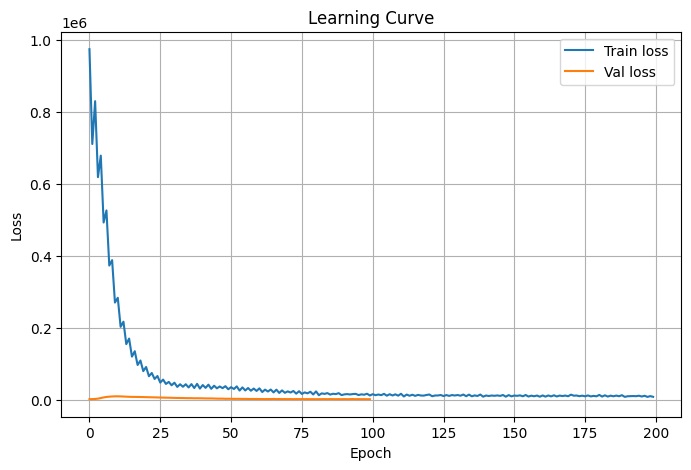

[973734.375, 710769.25, 829612.625, 618804.0625, 678589.75, 493028.375, 526499.125, 373604.96875, 388675.09375, 270941.65625, 284189.59375, 203630.671875, 217916.796875, 155695.53125, 171037.875, 121015.6640625, 135988.9375, 97788.5625, 110212.96875, 80779.484375, 92262.609375, 66638.390625, 75602.40625, 59063.2265625, 67193.9609375, 48988.79296875, 57327.390625, 45194.828125, 50880.82421875, 41575.4921875, 48677.13671875, 36990.7109375, 44304.1015625, 37419.9921875, 44383.4765625, 35484.16015625, 44772.27734375, 33930.4140625, 45480.8828125, 32405.6953125, 42150.140625, 34345.8984375, 43222.8515625, 31673.890625, 40273.65625, 33094.4453125, 38141.5078125, 33556.5390625, 39024.4921875, 30495.095703125, 36253.88671875, 31160.1015625, 38439.8359375, 26837.927734375, 35655.12890625, 27170.146484375, 33877.8984375, 26389.91015625, 32427.31640625, 25833.23828125, 32988.3515625, 22824.900390625, 29412.3671875, 24210.640625, 29682.80078125, 21739.703125, 29293.69921875, 20343.357421875, 27301

In [ ]:
losses = [loss.cpu().item() if hasattr(loss, 'cpu') else float(loss) for loss in model.losses]
val_losses = [loss.cpu().item() if hasattr(loss, 'cpu') else float(loss) for loss in model.val_losses]
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()
print(losses)

Input: shape=torch.Size([49, 1, 6067])
After layer 0: shape=torch.Size([49, 512, 380])
After layer 1: shape=torch.Size([49, 1024, 48])
After layer 2: shape=torch.Size([49, 2048, 1])
Input: shape=torch.Size([49, 1024])
After reshape: shape=torch.Size([49, 1024, 1])
After layer 0: shape=torch.Size([49, 512, 48])
After layer 1: shape=torch.Size([49, 256, 378])
After layer 2: shape=torch.Size([49, 1, 6034])
Acceleration


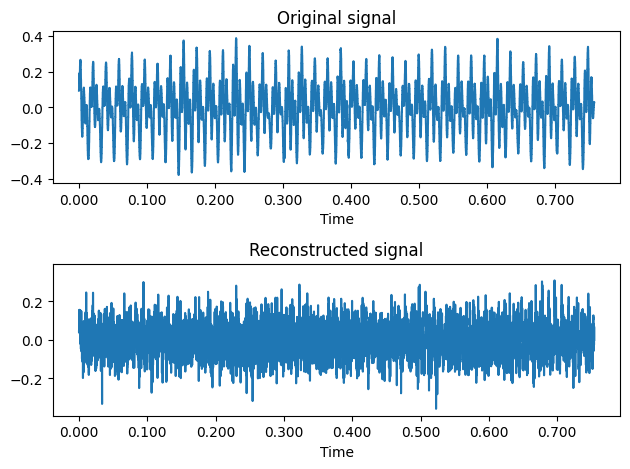

In [ ]:
x = dataset[80][0].unsqueeze(1)
x = x.to(device)
label = 0
model.eval()
with torch.no_grad():
    sounds, labels, emg_signals = next(iter(loader))
    x = sounds[10,0].cpu().numpy()
    label = int(labels[0].cpu())
    sounds = sounds.to(device)
    labels = labels.to(device)
    emg_signals = emg_signals.to(device)
    #emg_signal = torch.randn(1, 1, 2000).to(device)
    recon, _,_ = model(sounds, labels, emg_signals)

if label == 0:
  print('Acceleration')
else:
  print('Breaking')
display(IPython.display.Audio(sounds[0,0].cpu().numpy().squeeze(), rate = sr))
signal = recon[0].cpu().numpy().squeeze()
signal_and_augmented_signal(sounds[0,0].cpu().numpy().squeeze(),signal,sr=sr)
display(IPython.display.Audio(signal, rate = sr))

In [ ]:
torch.save({
    'emg': model.emg.state_dict(),
    'encoder': model.encoder.state_dict(),
    'decoder': model.decoder.state_dict(),
    'class_embed_emg': model.class_embed_emg.state_dict(),
    'class_embed_labels': model.class_embed_labels.state_dict(),
    'class_embed_conctatination': model.class_embed_conctatination.state_dict(),
    'losses': model.losses,
    'val_losses': model.val_losses,
}, "SoundVAE1.pth")


#emg_signal = torch.randn(1, 1, 2000).to(device)

# Оценка

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Оценка модели на тестовых данных
    Возвращает:
    - test_loss: средняя ошибка на тестовом наборе
    - accuracy: точность классификации
    - classification_rep: отчет по метрикам классификации
    - confusion_mtx: матрица ошибок
    - generated_images: сгенерированные изображения для визуализации
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    # Для хранения предсказаний и меток
    all_preds = []
    all_labels = []
    generated_images = []

    with torch.no_grad():
        for signals, images, labels in tqdm(test_loader, desc="Testing"):
            signals = signals.to(device)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            recon_images, _, class_logits = model(signals, images)

            # Расчет ошибки реконструкции
            loss = torch.nn.functional.mse_loss(recon_images, images)
            test_loss += loss.item()

            # Расчет точности классификации
            _, predicted = torch.max(class_logits, 1)
            _, true_labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()

            # Сохраняем для метрик
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

            # Сохраняем примеры для визуализации
            if len(generated_images) < 10:  # Сохраняем первые 10 примеров
                generated_images.append({
                    'original': images[0].cpu(),
                    'reconstructed': recon_images[0].cpu(),
                    'signal': signals[0].cpu(),
                    'true_label': true_labels[0].item(),
                    'pred_label': predicted[0].item()
                })

    # Средняя ошибка и точность
    test_loss /= len(test_loader)
    accuracy = correct / total

    # Отчет по классификации
    class_names = [f"Class_{i}" for i in range(labels.size(1))]
    classification_rep = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        digits=4
    )

    # Матрица ошибок
    confusion_mtx = confusion_matrix(all_labels, all_preds)

    # Визуализация
    plot_results(generated_images, confusion_mtx, class_names)

    return {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'classification_report': classification_rep,
        'confusion_matrix': confusion_mtx,
        'generated_samples': generated_images
    }

def plot_results(samples, confusion_mtx, class_names):
    """Визуализация результатов"""
    plt.figure(figsize=(15, 10))

    # 1. Примеры реконструкции
    plt.subplot(2, 2, 1)
    plt.imshow(samples[0]['original'].squeeze(), cmap='gray')
    plt.title(f"Original (Class {samples[0]['true_label']})")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(samples[0]['reconstructed'].squeeze(), cmap='gray')
    plt.title(f"Reconstructed (Pred {samples[0]['pred_label']})")
    plt.axis('off')

    # 2. Сигнал
    plt.subplot(2, 2, 3)
    plt.plot(samples[0]['signal'].squeeze().numpy())
    plt.title("Input Signal")

    # 3. Матрица ошибок
    plt.subplot(2, 2, 4)
    sns.heatmap(confusion_mtx, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.tight_layout()
    plt.show()

In [ ]:
#torch.save(model.state_dict(), 'cvae_emg.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_read = CombinedModel(
    input_size=3000,  # Примерная длина сигнала
    num_classes=3,   # Количество классов
    pretrained_cnn_path="model10_500.pth",
    pretrained_vae_path="cvae_class.pth",
    freeze_cnn=True,  # Замораживаем всю CNN
    freeze_vae=True,  # Замораживаем всю VAE
    tune_cnn_last_layer=True  # Размораживаем последний слой CNN
    ).to(device)

model_read.load_state_dict(torch.load('cvae_emg.pth', weights_only=True))

In [ ]:
# Оценка модели
results = evaluate_model(model, test_loader, device)

# Вывод результатов
print(f"\nTest Loss: {results['test_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.4f}")
print("\nClassification Report:")
print(results['classification_report'])

# VAE

## Encoder Class

In [ ]:
class Encoder(nn.Module):
    def __init__(self, im_chan=1, output_chan=32, hidden_dim=64):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.encoder = nn.Sequential(
            self.init_conv_block(1, 512),
            self.init_conv_block(512, 1024, kernel_size=32, stride=8, padding=15,),
            self.init_conv_block(1024, 2048, kernel_size=48, stride=1, padding=0, final_layer=True),
        )

    def init_conv_block(self, input_channels, output_channels, kernel_size=64, stride=16, padding=31, final_layer=False, bias=True):
        layers = [
            nn.Conv1d(input_channels, output_channels,
                          kernel_size=kernel_size,
                          padding=padding,
                          stride=stride)
        ]
        if not final_layer:
            layers += [
                nn.BatchNorm1d(output_channels),
                nn.ReLU()
            ]
        else:
            layers += [nn.Tanh()]
        return nn.Sequential(*layers)

    def forward(self, sound):
        x = sound
        print(f"Input: shape={x.shape}")
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            print(f"After layer {i}: shape={x.shape}")
        #print(x)
        encoding = x.view(len(x), -1)
        #print(encoding)
        #print(encoding.shape)
        #encoder_pred = self.encoder(sound)
        #encoding = encoder_pred.view(len(encoder_pred), -1)
        mean = encoding[:, :self.z_dim]
        logvar = encoding[:, self.z_dim:]
        return mean, torch.exp(logvar*0.5)


## Decoder Class

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=32):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.decoder = nn.Sequential(
            self.init_conv_block(1024, 512, kernel_size=48, stride=1, padding=0),
            self.init_conv_block(512,256, kernel_size=32, stride=8, padding=15,),
            self.init_conv_block(256, 1, final_layer=True),
        )

    def init_conv_block(self, input_channels, output_channels, kernel_size=64, stride=16, padding=31, final_layer=False, bias=True):
        layers = [
            nn.ConvTranspose1d(input_channels, output_channels,
                               kernel_size=kernel_size,
                               stride=stride, padding=padding)
        ]
        if not final_layer:
            layers += [
                nn.BatchNorm1d(output_channels),
                nn.ReLU()
            ]
        return nn.Sequential(*layers)

    def forward(self, z):
        x = z
        print(f"Input: shape={x.shape}")
        x = x.unsqueeze(2)
        #x = z.view(-1, self.z_dim, 1)
        print(f"After reshape: shape={x.shape}")
        for i, layer in enumerate(self.decoder):
            x = layer(x)
            print(f"After layer {i}: shape={x.shape}")
        return x
        #return self.decoder(x)

## VAE Model Class

In [ ]:
class VAE(nn.Module):
  def __init__(self, z_dim=32, im_chan=1, class_dim=32, num_classes=2):
    super(VAE, self).__init__()
    self.z_dim = z_dim
    self.encoder = Encoder(im_chan, z_dim, )
    self.decoder = Decoder(z_dim, im_chan, )
    #self.class_embed = ClassEmbedder(num_classes, class_dim)
    self.losses = []
    self.class_embed_labels = ClassEmbedder(num_classes, 512)
    self.class_embed_conctatination = FullConnected(1024, z_dim)

  def match_length(self,x, target_length):
    current_length = x.shape[-1]
    if current_length == target_length:
      return x
    elif current_length > target_length:
        return x[..., :target_length]
    else:
        pad_len = target_length - current_length
        return F.pad(x, (0, pad_len))

  def forward(self, sounds, labels):
    mean, std = self.encoder(sounds)
    #print(mean)
    z_dist = Normal(mean, std)
    z = z_dist.rsample()
    #print(z)
    #z = z.unsqueeze(2)
    print(z.shape)
    #print()
    #class_vec_labels = self.class_embed_labels(labels)
    #z = torch.cat([z, class_vec_labels], dim=1)
    #z = self.class_embed_conctatination(z)
    print(z.shape)
    decoding = self.decoder(z)
    return decoding, z_dist

## KL divergence

In [ ]:
from torch.distributions.kl import kl_divergence
def kl_divergence_loss(z_dist):
    return kl_divergence(z_dist,
                         Normal(torch.zeros_like(z_dist.mean),
                                torch.ones_like(z_dist.stddev))
                         ).sum(-1).sum()

## Reconstruction loss

In [ ]:
reconstruction_loss = nn.MSELoss(reduction='sum')

## Train VAE

In [ ]:
def train_model(epochs=10, z_dim = 32):
  model = VAE(z_dim=z_dim).to(device)
  model_opt = torch.optim.Adam(model.parameters(),) #lr = 5e-5, weight_decay=5e-5)
  for epoch in range(epochs):
      model.train()
      print(f"Epoch {epoch}")
      for sounds, labels, _ in tqdm(loader):
          sounds = sounds.to(device)
          labels = labels.to(device)
          model_opt.zero_grad()
          recon_sounds, encoding = model(sounds, labels)
          recon_sounds = model.match_length(recon_sounds, sounds.shape[-1])
          loss = reconstruction_loss(recon_sounds, sounds) # + kl_divergence_loss(encoding)
          model.losses.append(loss)
          loss.backward()
          #nn_utils.clip_grad_norm_(model.parameters(), max_norm=1000.0)
          model_opt.step()
          #original = sounds[0, 0].detach().cpu().numpy()
          #reconstructed = recon_sounds[0, 0].detach().cpu().numpy()
          #signal_and_augmented_signal(original,reconstructed,sr=sr)
          #print("loss:", loss.item())

  return model

In [ ]:
z_dim = 256
vae = train_model(epochs=100, z_dim=z_dim)

Epoch 0


  0%|          | 0/6 [00:00<?, ?it/s]

Input: shape=torch.Size([16, 1, 6067])
After layer 0: shape=torch.Size([16, 64, 759])
After layer 1: shape=torch.Size([16, 128, 95])
After layer 2: shape=torch.Size([16, 256, 24])
After layer 3: shape=torch.Size([16, 512, 6])
After layer 4: shape=torch.Size([16, 512, 1])
torch.Size([16, 512])
torch.Size([16, 512])
Input: shape=torch.Size([16, 512])
After reshape: shape=torch.Size([16, 512, 1])
After layer 0: shape=torch.Size([16, 512, 6])
After layer 1: shape=torch.Size([16, 256, 52])
After layer 2: shape=torch.Size([16, 128, 236])
After layer 3: shape=torch.Size([16, 64, 1912])
After layer 4: shape=torch.Size([16, 1, 15352])


 17%|█▋        | 1/6 [00:04<00:20,  4.01s/it]

Input: shape=torch.Size([16, 1, 6067])
After layer 0: shape=torch.Size([16, 64, 759])
After layer 1: shape=torch.Size([16, 128, 95])
After layer 2: shape=torch.Size([16, 256, 24])
After layer 3: shape=torch.Size([16, 512, 6])
After layer 4: shape=torch.Size([16, 512, 1])
torch.Size([16, 512])
torch.Size([16, 512])
Input: shape=torch.Size([16, 512])
After reshape: shape=torch.Size([16, 512, 1])
After layer 0: shape=torch.Size([16, 512, 6])
After layer 1: shape=torch.Size([16, 256, 52])
After layer 2: shape=torch.Size([16, 128, 236])
After layer 3: shape=torch.Size([16, 64, 1912])
After layer 4: shape=torch.Size([16, 1, 15352])


 33%|███▎      | 2/6 [00:05<00:09,  2.49s/it]

Input: shape=torch.Size([16, 1, 6067])
After layer 0: shape=torch.Size([16, 64, 759])
After layer 1: shape=torch.Size([16, 128, 95])
After layer 2: shape=torch.Size([16, 256, 24])
After layer 3: shape=torch.Size([16, 512, 6])
After layer 4: shape=torch.Size([16, 512, 1])
torch.Size([16, 512])
torch.Size([16, 512])
Input: shape=torch.Size([16, 512])
After reshape: shape=torch.Size([16, 512, 1])
After layer 0: shape=torch.Size([16, 512, 6])
After layer 1: shape=torch.Size([16, 256, 52])
After layer 2: shape=torch.Size([16, 128, 236])
After layer 3: shape=torch.Size([16, 64, 1912])
After layer 4: shape=torch.Size([16, 1, 15352])


 50%|█████     | 3/6 [00:07<00:06,  2.08s/it]

Input: shape=torch.Size([16, 1, 6067])
After layer 0: shape=torch.Size([16, 64, 759])
After layer 1: shape=torch.Size([16, 128, 95])
After layer 2: shape=torch.Size([16, 256, 24])
After layer 3: shape=torch.Size([16, 512, 6])
After layer 4: shape=torch.Size([16, 512, 1])
torch.Size([16, 512])
torch.Size([16, 512])
Input: shape=torch.Size([16, 512])
After reshape: shape=torch.Size([16, 512, 1])
After layer 0: shape=torch.Size([16, 512, 6])
After layer 1: shape=torch.Size([16, 256, 52])
After layer 2: shape=torch.Size([16, 128, 236])
After layer 3: shape=torch.Size([16, 64, 1912])
After layer 4: shape=torch.Size([16, 1, 15352])


 67%|██████▋   | 4/6 [00:08<00:03,  1.72s/it]

Input: shape=torch.Size([16, 1, 6067])
After layer 0: shape=torch.Size([16, 64, 759])
After layer 1: shape=torch.Size([16, 128, 95])
After layer 2: shape=torch.Size([16, 256, 24])
After layer 3: shape=torch.Size([16, 512, 6])
After layer 4: shape=torch.Size([16, 512, 1])
torch.Size([16, 512])
torch.Size([16, 512])
Input: shape=torch.Size([16, 512])
After reshape: shape=torch.Size([16, 512, 1])
After layer 0: shape=torch.Size([16, 512, 6])
After layer 1: shape=torch.Size([16, 256, 52])
After layer 2: shape=torch.Size([16, 128, 236])
After layer 3: shape=torch.Size([16, 64, 1912])
After layer 4: shape=torch.Size([16, 1, 15352])


 83%|████████▎ | 5/6 [00:09<00:01,  1.39s/it]

Input: shape=torch.Size([9, 1, 6067])
After layer 0: shape=torch.Size([9, 64, 759])
After layer 1: shape=torch.Size([9, 128, 95])
After layer 2: shape=torch.Size([9, 256, 24])
After layer 3: shape=torch.Size([9, 512, 6])
After layer 4: shape=torch.Size([9, 512, 1])
torch.Size([9, 512])
torch.Size([9, 512])
Input: shape=torch.Size([9, 512])
After reshape: shape=torch.Size([9, 512, 1])
After layer 0: shape=torch.Size([9, 512, 6])
After layer 1: shape=torch.Size([9, 256, 52])
After layer 2: shape=torch.Size([9, 128, 236])
After layer 3: shape=torch.Size([9, 64, 1912])
After layer 4: shape=torch.Size([9, 1, 15352])


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


Epoch 1


  0%|          | 0/6 [00:00<?, ?it/s]

Input: shape=torch.Size([16, 1, 6067])
After layer 0: shape=torch.Size([16, 64, 759])
After layer 1: shape=torch.Size([16, 128, 95])
After layer 2: shape=torch.Size([16, 256, 24])
After layer 3: shape=torch.Size([16, 512, 6])
After layer 4: shape=torch.Size([16, 512, 1])
torch.Size([16, 512])
torch.Size([16, 512])
Input: shape=torch.Size([16, 512])
After reshape: shape=torch.Size([16, 512, 1])
After layer 0: shape=torch.Size([16, 512, 6])
After layer 1: shape=torch.Size([16, 256, 52])
After layer 2: shape=torch.Size([16, 128, 236])
After layer 3: shape=torch.Size([16, 64, 1912])
After layer 4: shape=torch.Size([16, 1, 15352])


 17%|█▋        | 1/6 [00:01<00:06,  1.20s/it]

Input: shape=torch.Size([16, 1, 6067])
After layer 0: shape=torch.Size([16, 64, 759])
After layer 1: shape=torch.Size([16, 128, 95])
After layer 2: shape=torch.Size([16, 256, 24])
After layer 3: shape=torch.Size([16, 512, 6])
After layer 4: shape=torch.Size([16, 512, 1])
torch.Size([16, 512])
torch.Size([16, 512])
Input: shape=torch.Size([16, 512])
After reshape: shape=torch.Size([16, 512, 1])
After layer 0: shape=torch.Size([16, 512, 6])
After layer 1: shape=torch.Size([16, 256, 52])
After layer 2: shape=torch.Size([16, 128, 236])
After layer 3: shape=torch.Size([16, 64, 1912])
After layer 4: shape=torch.Size([16, 1, 15352])


 33%|███▎      | 2/6 [00:02<00:03,  1.01it/s]

Input: shape=torch.Size([16, 1, 6067])
After layer 0: shape=torch.Size([16, 64, 759])
After layer 1: shape=torch.Size([16, 128, 95])
After layer 2: shape=torch.Size([16, 256, 24])
After layer 3: shape=torch.Size([16, 512, 6])
After layer 4: shape=torch.Size([16, 512, 1])
torch.Size([16, 512])
torch.Size([16, 512])
Input: shape=torch.Size([16, 512])
After reshape: shape=torch.Size([16, 512, 1])
After layer 0: shape=torch.Size([16, 512, 6])
After layer 1: shape=torch.Size([16, 256, 52])
After layer 2: shape=torch.Size([16, 128, 236])
After layer 3: shape=torch.Size([16, 64, 1912])
After layer 4: shape=torch.Size([16, 1, 15352])


 33%|███▎      | 2/6 [00:02<00:05,  1.39s/it]


KeyboardInterrupt: 

In [ ]:
x = dataset[8][0].unsqueeze(1)
display(IPython.display.Audio(x.squeeze(), rate = sr))


In [ ]:
device = next(vae.parameters()).device  # автоматически определяет, где модель (cpu или cuda)
x = x.to(device)
vae.eval()
with torch.no_grad():
    mean, std = vae.encoder(x)
    z_dist = Normal(mean, std)
    z = mean #z_dist.rsample()
    recon = vae.decoder(z)


print(recon.shape)
signal = recon[0,0].cpu().numpy()
display(IPython.display.Audio(signal, rate = sr))

Input: shape=torch.Size([1, 1, 6067])
After layer 0: shape=torch.Size([1, 64, 759])
After layer 1: shape=torch.Size([1, 128, 95])
After layer 2: shape=torch.Size([1, 256, 24])
After layer 3: shape=torch.Size([1, 512, 6])
After layer 4: shape=torch.Size([1, 512, 1])
Input: shape=torch.Size([1, 512])
After reshape: shape=torch.Size([1, 512, 1])
After layer 0: shape=torch.Size([1, 512, 48])
After layer 1: shape=torch.Size([1, 256, 378])
After layer 2: shape=torch.Size([1, 1, 6034])
torch.Size([1, 1, 6034])


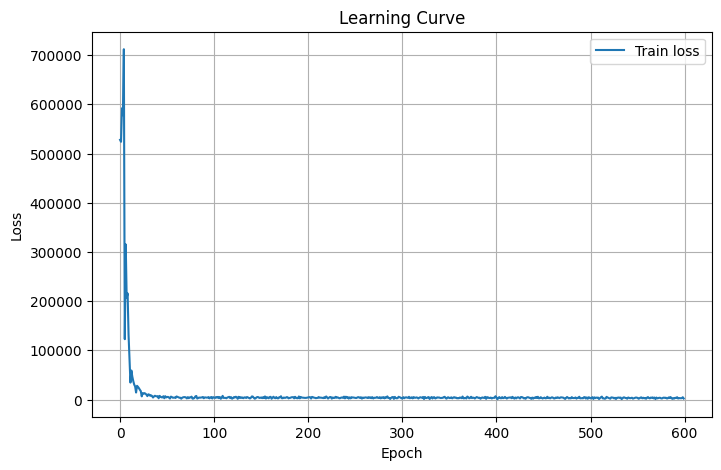

[527793.1875, 523848.46875, 591971.5, 577857.4375, 712003.25, 122627.1484375, 315224.125, 206828.21875, 215607.78125, 131793.1875, 82827.15625, 34412.4375, 58949.64453125, 46426.796875, 37522.0703125, 30419.8125, 26414.53125, 14235.37109375, 27834.818359375, 25730.330078125, 23068.048828125, 19888.7421875, 17151.21875, 6385.5185546875, 12979.4453125, 12060.5029296875, 12954.75390625, 11753.0244140625, 9928.599609375, 6906.9716796875, 10579.880859375, 9834.8388671875, 7601.0947265625, 8416.96875, 7046.7890625, 4027.666015625, 6107.83544921875, 7580.052734375, 6802.60205078125, 6302.5283203125, 6853.1904296875, 2551.318359375, 7373.6865234375, 5653.85546875, 4464.0810546875, 4309.5830078125, 6620.5, 2603.54931640625, 6709.3935546875, 4253.6552734375, 5032.21630859375, 5328.73046875, 3887.218017578125, 2010.1005859375, 5872.1640625, 5013.87353515625, 3697.16455078125, 3745.971923828125, 4153.3896484375, 3148.83837890625, 6173.9306640625, 5238.66015625, 4513.6572265625, 3656.23828125, 3690

In [ ]:
losses = [loss.cpu().item() if hasattr(loss, 'cpu') else float(loss) for loss in vae.losses]
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()
print(losses)

In [ ]:
torch.save(vae, './full_model.pth')


In [ ]:
class Encoder(nn.Module):
    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.encoder = nn.Sequential(
            self.init_conv_block(im_chan, hidden_dim),
            self.init_conv_block(hidden_dim, hidden_dim * 2, kernel_size=32, stride=2, padding=0,),
            self.init_conv_block(hidden_dim * 2, output_chan, kernel_size=48, stride=2, padding=0, final_layer=True),
        )

    def init_conv_block(self, input_channels, output_channels, kernel_size=64, stride=2, padding=0, final_layer=False, bias=True):
        layers = [
            nn.Conv1d(input_channels, output_channels,
                          kernel_size=kernel_size,
                          padding=padding,
                          stride=stride)
        ]
        if not final_layer:
            layers += [
                nn.BatchNorm1d(output_channels),
                nn.ReLU()
            ]
        else:
            layers += [nn.Tanh()]
        return nn.Sequential(*layers)

    def forward(self, sound):
        x = sound
        print(f"Input: shape={x.shape}")
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            print(f"After layer {i}: shape={x.shape}")
        #print(x)
        encoding = x.view(len(x), -1)
        #print(encoding)
        #print(encoding.shape)
        #encoder_pred = self.encoder(sound)
        #encoding = encoder_pred.view(len(encoder_pred), -1)
        mean = encoding#[:, :self.z_dim]
        logvar = encoding#[:, self.z_dim:]
        return mean, torch.abs(logvar*0.5)


In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=32):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.decoder = nn.Sequential(
            self.init_conv_block(z_dim, hidden_dim * 2, kernel_size=48, stride=1, padding=0),
            self.init_conv_block(hidden_dim * 2, hidden_dim, kernel_size=32, stride=8, padding=0,),
            self.init_conv_block(hidden_dim, im_chan, final_layer=True),
        )

    def init_conv_block(self, input_channels, output_channels, kernel_size=64, stride=16, padding=0, final_layer=False, bias=True):
        layers = [
            nn.ConvTranspose1d(input_channels, output_channels,
                               kernel_size=kernel_size,
                               stride=stride, padding=padding)
        ]
        if not final_layer:
            layers += [
                nn.BatchNorm1d(output_channels),
                nn.ReLU()
            ]
        return nn.Sequential(*layers)

    def forward(self, z):
        x = z
        print(f"Input: shape={x.shape}")
        x = z.view(-1, self.z_dim, 1)
        print(f"After reshape: shape={x.shape}")
        for i, layer in enumerate(self.decoder):
            x = layer(x)
            print(f"After layer {i}: shape={x.shape}")
        return x
        #return self.decoder(x)